# Notebook for activation extraction protocol investigation

In this notebook we investigate how activation from each model should be retrieved.
Several factors were identified:
    - context
    - normalization
    - dimensionality reduction

In [4]:
import warnings
warnings.simplefilter(action='ignore')

import os
import gc
import glob
import itertools
from tqdm import tqdm
from itertools import combinations
from joblib import Parallel, delayed

import umap
import scipy
import hdbscan
import nistats
import numpy as np
import pandas as pd
from sklearn import manifold
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

import utils 
import reporting
from logger import Logger
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Paths

In [2]:
language = 'english'

In [3]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_95%_{language}"


In [5]:
PROJECT_PATH = f"/Users/alexpsq/Code/Parietal/maps"
INPUT_PATH = f"/Users/alexpsq/Code/Parietal/data/stimuli-representations/english"

### Atlas

In [6]:
atlas_maps, labels = reporting.load_atlas()

## Normalization

Here we look at the impact of normalization over fMRI BOLD signal model prediction.

Here we will only say that among BERT and GPT-2 activations, we found high variance activations for GPT-2 and low-variance activations for BERT.
GPT-2's regression performances were highly impacted by scaling anterior to the pipeline, while BERT wasn't.

## Context

Here we perform ANOVA analysis 

In [ ]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-0_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-1_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-2_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-5_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-10_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-15_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
    'gpt2_pre-0_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-1_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-2_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-5_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-10_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-15_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
    'gpt2_pre-20_1_norm-2_norm-2_{}_hidden-all-layers_pca_300'
]

In [ ]:
anova_context = reporting.prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

In [ ]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
check_folder(saving_folder)

In [ ]:
anova_context.to_csv(os.path.join(saving_path, 'anova_context.csv'), index=False)

TODO: Do the anova analysis on R.

## Dimensionality reduction

We investigate different dimensionality reduction technics (PCA, ICA, UMAP, Agglomerative Clustering).
We found that PCA and ICA had the best results, with a very sligh advantage of PCA which is also a lot faster.

In [ ]:
model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_50',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_100',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_150',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_500',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_pca_1000',
    
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_50',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_100',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_150',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_300',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_500',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_umap_1000',
    
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_ica_300',
    
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-all-layers_similarity_cluster_300',
]




In [ ]:
anova_reduction = reporting.prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

In [ ]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
check_folder(saving_folder)

In [ ]:
anova_reduction.to_csv(os.path.join(saving_path, 'anova_reduction.csv'), index=False)

TODO: Do the anova analysis on R.

We observe that keeping more than 300 components with the PCA is not necessary, as similar (averaged per ROI) results are achieved.

### PCA explained variance

In [10]:
model_name = 'bert-base-cased'# 'bert-base-cased_pre-7_1_post-0_norm-None'
plot_name = 'BERT PCA'

In [11]:
paths = sorted(glob.glob(os.path.join(INPUT_PATH, model_name, 'activation*')))

In [12]:
data = [pd.read_csv(path) for path in paths]

We only keep hidden states values:

In [13]:
dataframes = [d[d.keys()[:13*768]] for d in data]

In [14]:
X = [df.values for df in dataframes]

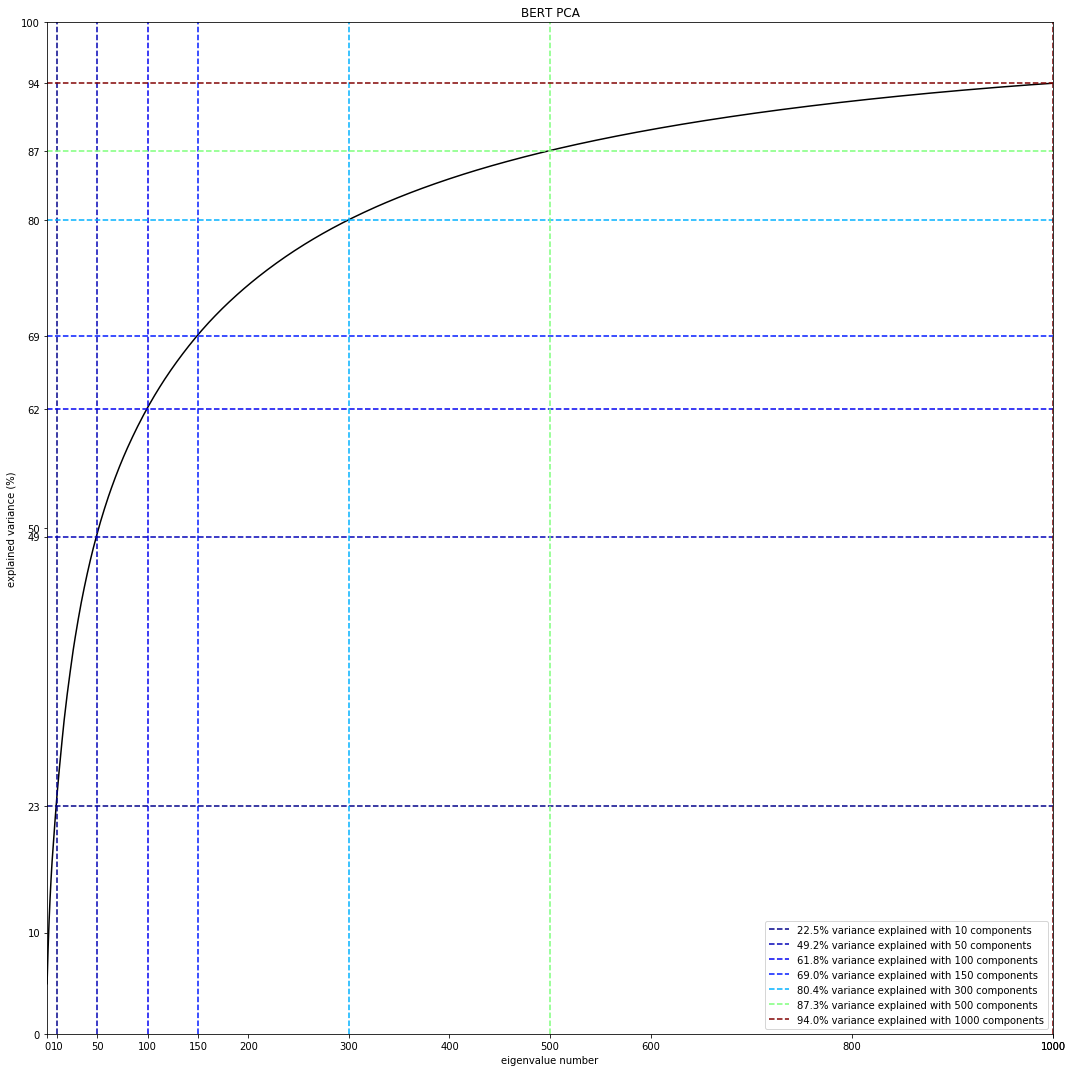

In [15]:
reporting.explained_variance(X, plot_name, n_components_max=1000, n_components_to_plot=[10, 50, 100, 150, 300, 500, 1000], saving_path=None)